In [17]:
import mysql.connector
import pandas as pd
from tensorflow.python.framework.test_ops import binary

# 1. Connexion à la base de données MySQL
connection = mysql.connector.connect(
    host="localhost",           # Adresse du serveur MySQL
    user="root",                # Nom d'utilisateur MySQL
    password="",  # Mot de passe MySQL
    database="scrapDB"   # Nom de la base de données
)

# 2. Créer un curseur pour exécuter la requête SQL
cursor = connection.cursor()

# 3. Exécuter la requête SQL pour récupérer les données de la table
query = "SELECT * FROM annonces"
cursor.execute(query)

# 4. Récupérer les résultats de la requête
results = cursor.fetchall()

# 5. Récupérer les noms des colonnes
column_names = [desc[0] for desc in cursor.description]

# 6. Convertir les résultats en DataFrame (dataset)
df = pd.DataFrame(results, columns=column_names)
# 8. Fermer la connexion
cursor.close()
connection.close()


2024-11-09 18:46:25.672135: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-09 18:46:25.790051: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-09 18:46:25.880586: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731174385.956975   45551 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731174385.983001   45551 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-09 18:46:26.169920: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.pipeline import Pipeline

In [19]:
df.head()

,id,titre,prix,quartier,ville,nb_chambres,nb_salles_de_bain,url,nb_vues,meuble,presence_parking,presence_barriere,date_publication
0,1,Appartement 4 chambres,300000,Ngousso,Yaoundé,4,3,https://storage.googleapis.com/koutchoumi-list...,65,0,1,1,2024-10-31
1,2,Appartement 2 chambres,250000,Mfandena,Yaoundé,2,1,https://storage.googleapis.com/koutchoumi-list...,48,0,1,1,2024-10-31
2,3,Appartement 2 chambres,250000,Essos,Yaoundé,2,2,https://storage.googleapis.com/koutchoumi-list...,76,0,1,1,2024-10-31
3,4,Appartement 2 chambres,700000,Bastos,Yaoundé,2,3,https://storage.googleapis.com/koutchoumi-list...,41,0,1,1,2024-10-31
4,5,Appartement 3 chambres,600000,Mbankolo,Yaoundé,3,4,https://storage.googleapis.com/koutchoumi-list...,85,0,1,1,2024-10-31


In [20]:
df.isna().sum()

id                     0
titre                  0
prix                   0
quartier               0
ville                  0
nb_chambres            0
nb_salles_de_bain      0
url                    0
nb_vues                0
meuble                 0
presence_parking       0
presence_barriere      0
date_publication     221
dtype: int64

In [21]:
df.isnull().sum()

id                     0
titre                  0
prix                   0
quartier               0
ville                  0
nb_chambres            0
nb_salles_de_bain      0
url                    0
nb_vues                0
meuble                 0
presence_parking       0
presence_barriere      0
date_publication     221
dtype: int64

In [22]:
df.duplicated().sum()

np.int64(0)

In [23]:
df.drop(columns=['url', 'date_publication', 'titre', 'id'], inplace=True)
df

,prix,quartier,ville,nb_chambres,nb_salles_de_bain,nb_vues,meuble,presence_parking,presence_barriere
0,300000,Ngousso,Yaoundé,4,3,65,0,1,1
1,250000,Mfandena,Yaoundé,2,1,48,0,1,1
2,250000,Essos,Yaoundé,2,2,76,0,1,1
3,700000,Bastos,Yaoundé,2,3,41,0,1,1
4,600000,Mbankolo,Yaoundé,3,4,85,0,1,1
...,...,...,...,...,...,...,...,...,...
1109,850000,Bonapriso,Douala,2,3,261,0,0,0
1110,900000,Bonapriso,Douala,3,2,177,0,1,1
1111,1200000,Bonapriso,Douala,3,2,136,0,1,1
1112,800000,Bonapriso,Douala,2,3,191,0,1,1


In [24]:
data_outliers = df[['nb_chambres', 'nb_salles_de_bain', 'nb_vues', 'prix']]

In [25]:
categorial = df[['quartier','ville']]

In [26]:
binary_data = df[['meuble', 'presence_parking', 'presence_barriere']]

In [27]:
 #Fonction pour détecter et remplacer les valeurs aberrantes avec les Bounds
def replace_outliers(df):
    for col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

In [28]:
replace_outliers(data_outliers)

/tmp/ipykernel_45551/2946915705.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
/tmp/ipykernel_45551/2946915705.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
/tmp/ipykernel_45551/2946915705.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [29]:
data = pd.concat([data_outliers, categorial, binary_data], axis=1)

In [30]:
data

,nb_chambres,nb_salles_de_bain,nb_vues,prix,quartier,ville,meuble,presence_parking,presence_barriere
0,4.0,3.0,65.0,300000.0,Ngousso,Yaoundé,0,1,1
1,2.0,1.0,48.0,250000.0,Mfandena,Yaoundé,0,1,1
2,2.0,2.0,76.0,250000.0,Essos,Yaoundé,0,1,1
3,2.0,3.0,41.0,700000.0,Bastos,Yaoundé,0,1,1
4,3.0,4.0,85.0,600000.0,Mbankolo,Yaoundé,0,1,1
...,...,...,...,...,...,...,...,...,...
1109,2.0,3.0,261.0,850000.0,Bonapriso,Douala,0,0,0
1110,3.0,2.0,177.0,900000.0,Bonapriso,Douala,0,1,1
1111,3.0,2.0,136.0,1200000.0,Bonapriso,Douala,0,1,1
1112,2.0,3.0,191.0,800000.0,Bonapriso,Douala,0,1,1


In [31]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data.ville = label_encoder.fit_transform(data.ville)
data

,nb_chambres,nb_salles_de_bain,nb_vues,prix,quartier,ville,meuble,presence_parking,presence_barriere
0,4.0,3.0,65.0,300000.0,Ngousso,1,0,1,1
1,2.0,1.0,48.0,250000.0,Mfandena,1,0,1,1
2,2.0,2.0,76.0,250000.0,Essos,1,0,1,1
3,2.0,3.0,41.0,700000.0,Bastos,1,0,1,1
4,3.0,4.0,85.0,600000.0,Mbankolo,1,0,1,1
...,...,...,...,...,...,...,...,...,...
1109,2.0,3.0,261.0,850000.0,Bonapriso,0,0,0,0
1110,3.0,2.0,177.0,900000.0,Bonapriso,0,0,1,1
1111,3.0,2.0,136.0,1200000.0,Bonapriso,0,0,1,1
1112,2.0,3.0,191.0,800000.0,Bonapriso,0,0,1,1


In [32]:
def frequency_encoder(data, column_name):
    """
    Encode les valeurs catégorielles d'une colonne en utilisant leur fréquence d'apparition.

    Paramètres:
    - data : DataFrame Pandas contenant les données.
    - column_name : nom de la colonne catégorielle à encoder.

    Retourne:
    - Une copie du DataFrame avec une colonne encodée par fréquence ajoutée.
    """
    # Créer une copie pour éviter de modifier l'original
    data_encoded = data.copy()
    
    # Calculer la fréquence d'apparition de chaque catégorie
    frequency_map = data[column_name].value_counts(normalize=True)
    
    # Remplacer les catégories par leur fréquence
    data_encoded[f"{column_name}_encoded"] = data[column_name].map(frequency_map)
    
    return data_encoded

In [33]:
data_encoded = frequency_encoder(data, 'quartier')
data_encoded

,nb_chambres,nb_salles_de_bain,nb_vues,prix,quartier,ville,meuble,presence_parking,presence_barriere,quartier_encoded
0,4.0,3.0,65.0,300000.0,Ngousso,1,0,1,1,0.013465
1,2.0,1.0,48.0,250000.0,Mfandena,1,0,1,1,0.059246
2,2.0,2.0,76.0,250000.0,Essos,1,0,1,1,0.006284
3,2.0,3.0,41.0,700000.0,Bastos,1,0,1,1,0.540395
4,3.0,4.0,85.0,600000.0,Mbankolo,1,0,1,1,0.008079
...,...,...,...,...,...,...,...,...,...,...
1109,2.0,3.0,261.0,850000.0,Bonapriso,0,0,0,0,0.105925
1110,3.0,2.0,177.0,900000.0,Bonapriso,0,0,1,1,0.105925
1111,3.0,2.0,136.0,1200000.0,Bonapriso,0,0,1,1,0.105925
1112,2.0,3.0,191.0,800000.0,Bonapriso,0,0,1,1,0.105925


In [34]:
data_clean = data_encoded.drop(['quartier'], axis=1)
data_clean

,nb_chambres,nb_salles_de_bain,nb_vues,prix,ville,meuble,presence_parking,presence_barriere,quartier_encoded
0,4.0,3.0,65.0,300000.0,1,0,1,1,0.013465
1,2.0,1.0,48.0,250000.0,1,0,1,1,0.059246
2,2.0,2.0,76.0,250000.0,1,0,1,1,0.006284
3,2.0,3.0,41.0,700000.0,1,0,1,1,0.540395
4,3.0,4.0,85.0,600000.0,1,0,1,1,0.008079
...,...,...,...,...,...,...,...,...,...
1109,2.0,3.0,261.0,850000.0,0,0,0,0,0.105925
1110,3.0,2.0,177.0,900000.0,0,0,1,1,0.105925
1111,3.0,2.0,136.0,1200000.0,0,0,1,1,0.105925
1112,2.0,3.0,191.0,800000.0,0,0,1,1,0.105925


In [35]:
X = data_clean.drop(['prix'], axis=1)
y = data_clean[['prix']]

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [37]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [38]:
# Importation des bibliothèques nécessaires
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Initialisation du modèle KNN avec le nombre de voisins (k) à 3
knn = KNeighborsRegressor(n_neighbors=3)

In [39]:
# Entraînement du modèle avec les données d'entraînement
knn.fit(X_train_sc, y_train)

KNeighborsRegressor(n_neighbors=3)

In [40]:
# Prédiction des prix avec les données de test
y_pred = knn.predict(X_test_sc)

In [41]:
y_pred

array([[ 433333.33333333],
       [ 430000.        ],
       [ 500000.        ],
       [ 550000.        ],
       [ 196666.66666667],
       [ 500000.        ],
       [ 433333.33333333],
       [1866666.66666667],
       [ 766666.66666667],
       [ 291666.66666667],
       [1166666.66666667],
       [1333333.33333333],
       [ 375000.        ],
       [1583333.33333333],
       [1050000.        ],
       [ 250000.        ],
       [ 700000.        ],
       [ 308333.33333333],
       [ 273333.33333333],
       [ 700000.        ],
       [1000000.        ],
       [ 220000.        ],
       [ 433333.33333333],
       [ 950000.        ],
       [ 360000.        ],
       [ 466666.66666667],
       [1666666.66666667],
       [ 850000.        ],
       [ 313333.33333333],
       [1116666.66666667],
       [ 650000.        ],
       [1266666.66666667],
       [1066666.66666667],
       [1200000.        ],
       [ 466666.66666667],
       [ 305000.        ],
       [ 273333.33333333],
 

In [43]:
# Évaluation du modèle
mse = mean_squared_error(y_test, y_pred)  # Erreur quadratique moyenne
rmse = np.sqrt(mse)  # Racine de l'erreur quadratique moyenne
r2 = r2_score(y_test, y_pred)  # Coefficient de détermination R^2

In [44]:
# Affichage des résultats d'évaluation
print(f"Erreur quadratique moyenne (MSE): {mse}")
print(f"Racine de l'erreur quadratique moyenne (RMSE): {rmse}")
print(f"R^2 Score: {r2}")

Erreur quadratique moyenne (MSE): 179969882516.9255
Racine de l'erreur quadratique moyenne (RMSE): 424228.5734329142
R^2 Score: 0.33269049581312393


In [45]:
from sklearn.metrics import classification_report
cr = classification_report(y_test, y_pred)

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

/tmp/ipykernel_45551/4075243363.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=chambre_counts.index, y=chambre_counts.values, palette="viridis")


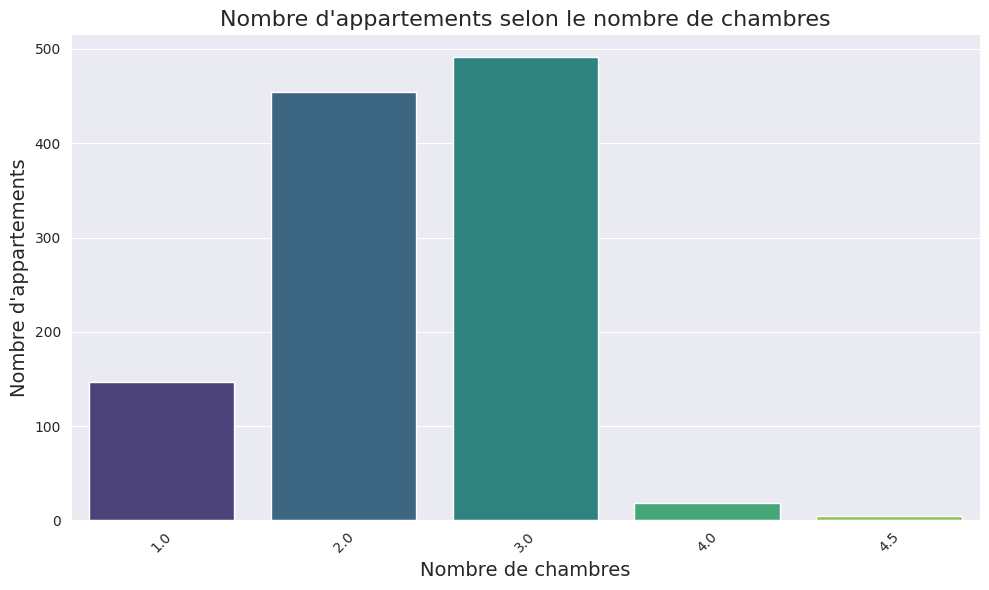

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Supposons que 'data_clean' est votre DataFrame qui contient les informations sur les appartements
# Assurez-vous que la colonne 'nb_chambres' contient bien les informations sur le nombre de chambres

# Calculer la fréquence des appartements en fonction du nombre de chambres
chambre_counts = data_clean['nb_chambres'].value_counts().sort_index()

# Affichage avec Seaborn (ou Matplotlib)
plt.figure(figsize=(10,6))
sns.barplot(x=chambre_counts.index, y=chambre_counts.values, palette="viridis")

# Personnalisation du graphique
plt.title('Nombre d\'appartements selon le nombre de chambres', fontsize=16)
plt.xlabel('Nombre de chambres', fontsize=14)
plt.ylabel('Nombre d\'appartements', fontsize=14)
plt.xticks(rotation=45)  # Rotation des étiquettes sur l'axe x si nécessaire
plt.tight_layout()

# Affichage du graphique
plt.show()
